# Anomaly Detection

In this project, we will implement the anomaly detection algorithm and apply it to detect failing servers on a network. 


## 1 - Packages 

First, let's run the cell below to import all the packages that we will need during this project.
- [numpy](www.numpy.org) is the fundamental package for working with matrices in Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- ``utils.py`` contains helper functions for this assignment.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline

## 2 - Anomaly detection

### 2.1 Problem Statement

In this project, we will implement an anomaly detection algorithm to
detect anomalous behavior in server computers.

### 2.2 Gaussian distribution

To perform anomaly detection, we will first need to fit a model to the data’s distribution.

* Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ we want to estimate the Gaussian distribution for each
of the features $x_i$. 

* The Gaussian distribution is given by

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where $\mu$ is the mean and $\sigma^2$ is the variance.
   
* For each feature $i = 1\ldots n$, we need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).

### 2.2.1 Estimating parameters for a Gaussian distribution

Here we will complete the `estimate_gaussian` function below to calculate `mu` (mean for each feature in `X`) and `var` (variance for each feature in `X`). 

We will estimate the parameters, ($\mu_i$, $\sigma_i^2$), of the $i$-th
feature by using the following equations. To estimate the mean, we will
use:

$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

and for the variance we will use:
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

In [2]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m, n = X.shape
    
    mu = np.sum(X, axis = 0) / m
    var = np.sum((X - mu) ** 2, axis = 0) / m
        
    return mu, var

### 2.2.2 Selecting the threshold $\epsilon$

Now that we have estimated the Gaussian parameters, we can investigate which examples have a very high probability given this distribution and which examples have a very low probability.  

* The low probability examples are more likely to be the anomalies in our dataset. 
* One way to determine which examples are anomalies is to select a threshold based on a cross validation set. 

In this section, we will write the code in `select_threshold` to select the threshold $\varepsilon$ using the $F_1$ score on a cross validation set.

* For this, we will use a cross validation set
$\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example. 
* For each cross validation example, we will compute $p(x_{\rm cv}^{(i)})$. The vector of all of these probabilities $p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv})})$ is passed to `select_threshold` in the vector `p_val`. 
* The corresponding labels $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv})}$ are passed to the same function in the vector `y_val`.

Here we will develop the `select_threshold` function below to find the best threshold to use for selecting outliers based on the results from the validation set (`p_val`) and the ground truth (`y_val`). 

* There is already a loop that will try many different values of $\varepsilon$ and select the best $\varepsilon$ based on the $F_1$ score. 

* We will implement code to calculate the F1 score from choosing `epsilon` as the threshold and place the value in `F1`. 

  * If an example $x$ has a low probability $p(x) < \varepsilon$, then it is classified as an anomaly. 
        
  * Then, we can compute precision and recall by: 
\begin{aligned}
\text{precision} &= \frac{tp}{tp+fp} \\
\text{recall} &= \frac{tp}{tp+fn},
\end{aligned} 
where
    * $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
    * $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
    * $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

  * The $F_1$ score is computed using precision ($prec$) and recall ($rec$) as follows:
    $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 

In [3]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 
    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    epsilon = 0.0001  # Small constant to prevent division by zero
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    

        
        predictions = (p_val < epsilon)
        
        
        # True Positives (tp): Predicted 1, Actual 1
        tp = np.sum((predictions == 1) & (y_val == 1))

        # True Negatives (tn): Predicted 0, Actual 0
        tn = np.sum((predictions == 0) & (y_val == 0))

        # False Positives (fp): Predicted 1, Actual 0
        fp = np.sum((predictions == 1) & (y_val == 0))

        # False Negatives (fn): Predicted 0, Actual 1
        fn = np.sum((predictions == 0) & (y_val == 1))
        

        # Check for zero denominator before calculating precision
        if (tp + fp) > 0:
            prec = tp / (tp + fp)
        else:
            prec = 0  # Precision is undefined when there are no predicted positives, handle accordingly

        # Check for zero denominator before calculating recall
        if (tp + fn) > 0:
            rec = tp / (tp + fn)
        else:
            rec = 0  # Recall is undefined when there are no true positives, handle accordingly

        # Calculate F1 score only if both precision and recall are defined
        if (prec + rec) > 0:
            F1 = 2 * prec * rec / (prec + rec)
        else:
            F1 = 0  # F1 is undefined if both precision and recall are zero
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

### 2.3 High dimensional dataset

Now,  we will run the anomaly detection algorithm that we implemented on a realistic dataset.

In this dataset, each example is described by 11 features, capturing many properties of compute servers.

Let's start by loading the dataset.

- The `load_data()` function shown below loads the data into variables `X_train`, `X_val` and `y_val`
    - We will use `X_train` to fit Gaussian distribution 
    - We will use `X_val` and `y_val` as a cross validation set to select a threshold and determine anomalous vs normal examples

In [4]:
# load the dataset
X_train, X_val, y_val = load_data_multi()

#### Check the dimensions of your variables

Let's check the dimensions of these new variables to become familiar with the data

In [5]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of X_val is:', X_val.shape)
print ('The shape of y_val is: ', y_val.shape)

The shape of X_train is: (1000, 11)
The shape of X_val is: (100, 11)
The shape of y_val is:  (100,)


#### Anomaly detection 

Now, let's run the anomaly detection algorithm on this dataset.

The code below will use our code to 
* Estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$)
* Evaluate the probabilities for both the training data `X_train` from which we estimated the Gaussian parameters, as well as for the the cross-validation set `X_val`. 
* Finally, it will use `select_threshold` to find the best threshold $\varepsilon$. 

In [6]:
# Apply the steps

# Estimate the Gaussian parameters
mu, var = estimate_gaussian(X_train)

# Evaluate the probabilites for the training set
p = multivariate_gaussian(X_train, mu, var)

# Evaluate the probabilites for the cross validation set
p_val = multivariate_gaussian(X_val, mu, var)

# Find the best threshold
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: %e'% epsilon)
print('Best F1 on Cross Validation Set:  %f'% F1)
print('# Anomalies found: %d'% sum(p < epsilon))

Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385
# Anomalies found: 117


<table>
  <tr>
    <td> <b>Best epsilon found using cross-validation: <b>  </td> 
    <td> 1.38e-18</td> 
   </tr>    
   <tr>
    <td> <b>Best F1 on Cross Validation Set: <b>  </td>
     <td> 0.615385 </td> 
  </tr>
    <tr>
    <td> <b># anomalies found: <b>  </td>
     <td>  117 </td> 
  </tr>
</table>

### PCA-Based Visualization of Anomaly Detection Results

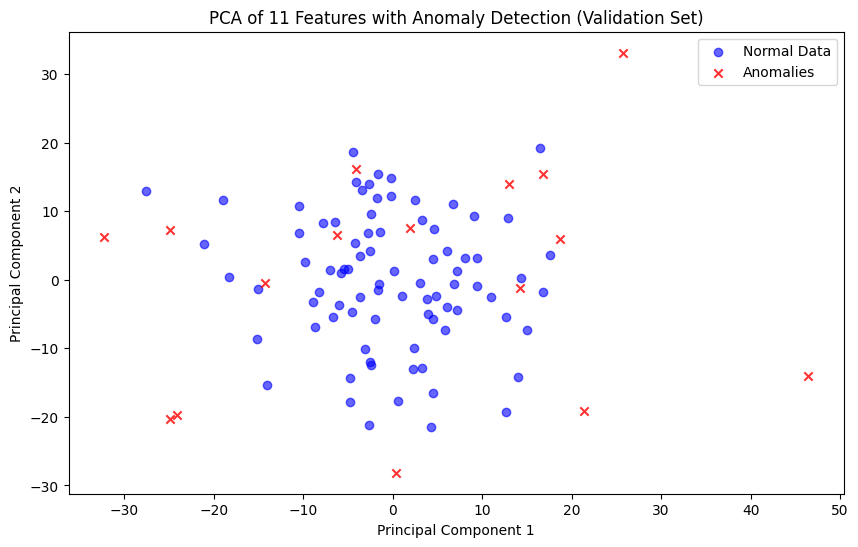

In [7]:
from sklearn.decomposition import PCA

# Perform PCA on the validation set (X_val) to reduce the 11-dimensional data to 2 dimensions.
# PCA helps visualize the high-dimensional data by projecting it into a 2D space.
pca = PCA(n_components=2)
X_val_pca = pca.fit_transform(X_val)

# Identify anomalies by checking where p_val (the predicted probabilities from the model)
# is less than the epsilon (the determined threshold for anomaly detection).
anomalies = X_val_pca[p_val < epsilon]

# Identify normal data points by checking where p_val is greater than or equal to epsilon.
normal_data = X_val_pca[p_val >= epsilon]

# Plot the PCA-reduced data
plt.figure(figsize=(10, 6))

# Plot the normal data points in blue
plt.scatter(normal_data[:, 0], normal_data[:, 1], label="Normal Data", alpha=0.6, c='b')

# Plot the detected anomalies in red with 'x' markers
plt.scatter(anomalies[:, 0], anomalies[:, 1], label="Anomalies", alpha=0.8, c='r', marker='x')

# Add title and labels for clarity
plt.title("PCA of 11 Features with Anomaly Detection (Validation Set)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Add a legend to distinguish between normal data and anomalies
plt.legend()

# Show the plot
plt.show()


In this step, we use Principal Component Analysis (PCA) to reduce the high-dimensional data from 11 features to 2 dimensions for better visualization. This allows us to project the data onto a 2D plane, where we can easily distinguish between normal data points and anomalies.

PCA helps us simplify the complexity of the dataset, which has 11 dimensions, by transforming the data into two principal components that capture the most significant variance in the dataset. This transformation enables us to visualize the results of our anomaly detection algorithm.

We use the predicted probabilities (p_val) and the optimized threshold (epsilon) to classify data points as either normal or anomalous. If a data point's probability is lower than the threshold, it is classified as an anomaly; otherwise, it is considered normal. The anomalies are plotted as red "x" markers, while the normal data points are plotted in blue.

By visualizing the results on the validation set, we can visually assess the performance of our anomaly detection algorithm. The plot shows how well the model separates normal data points from anomalies in a 2D space, making it easier to analyze whether the algorithm is correctly identifying outliers.

This visualization technique is particularly useful for evaluating unsupervised learning models where the ground truth for anomalies is often unknown. It helps us understand how the algorithm performs in practice and identify areas for further improvement in anomaly detection.

We can see that the algorithm performs pretty well in identifying anomalies, as evident from the visualization. The detected anomalies (marked in red) are clearly separated from the main cluster of normal data points, indicating that the model is successfully capturing the major anomalies in the dataset. This result suggests that the model effectively balances precision and recall in anomaly detection, achieving a good separation between normal data and outliers.